In [32]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'lungs-disease-dataset-4-types:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1864500%2F3044546%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240229%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240229T214701Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db7e20275102ad0a180f27953091a5f28f9463a7333b1b160a0dd465901e31f37f41585f4b82147f6fabe8553065c796f50e8676bd150fd7774d2ab57260e0a25fd7960657d42b77ec462463710e103a40a0f56449e8854b2b0796c20af6799abe06e94e89910d652c20479b9b4d02b18644aa46faab6eadcab33c2369ef9f07c93f24f741df781a5cd794958aa9abf34b8bbd7f654b8e54b80d68424ca7f612540188b5c2d0bcc968a5ff3a493134551beb1706091babb98f0d254c934973bc23b248c6152adccaadfc71713714a8bd11ef245bc5001d6be70fd05f04d7e198df1afc9f1784847407b805a7e25bba2b95503c7f3a9b3ff69a1d73dd4a858ce59'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2169396481 bytes downloaded
Downloaded and uncompressed: lungs-disease-dataset-4-types
Data source import complete.


In [33]:
import os
import cv2
import numpy as np
import pandas as pd
from warnings import filterwarnings
filterwarnings(action="ignore")

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers, callbacks
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

In [34]:
data_path = "/kaggle/input/lungs-disease-dataset-4-types/Lung Disease Dataset"

data = {"images":[], "labels":[], "split_type":[]}
for i in os.listdir(data_path): # Data Split
    split_dir = os.path.join(data_path, i)
    for j in os.listdir(split_dir): # Disease
        d_l = os.path.join(split_dir, j)
        for k in os.listdir(d_l):
            data["images"].append(os.path.join(d_l, k))
            data["labels"].append(j)
            data["split_type"].append(i)

df = pd.DataFrame(data)

print(df.shape)

df.head()

(10095, 3)


,images,labels,split_type
0,/kaggle/input/lungs-disease-dataset-4-types/Lu...,Viral Pneumonia,test
1,/kaggle/input/lungs-disease-dataset-4-types/Lu...,Viral Pneumonia,test
2,/kaggle/input/lungs-disease-dataset-4-types/Lu...,Viral Pneumonia,test
3,/kaggle/input/lungs-disease-dataset-4-types/Lu...,Viral Pneumonia,test
4,/kaggle/input/lungs-disease-dataset-4-types/Lu...,Viral Pneumonia,test


In [35]:
df["labels"].value_counts()

Tuberculosis            2034
Corona Virus Disease    2031
Normal                  2013
Bacterial Pneumonia     2009
Viral Pneumonia         2008
Name: labels, dtype: int64

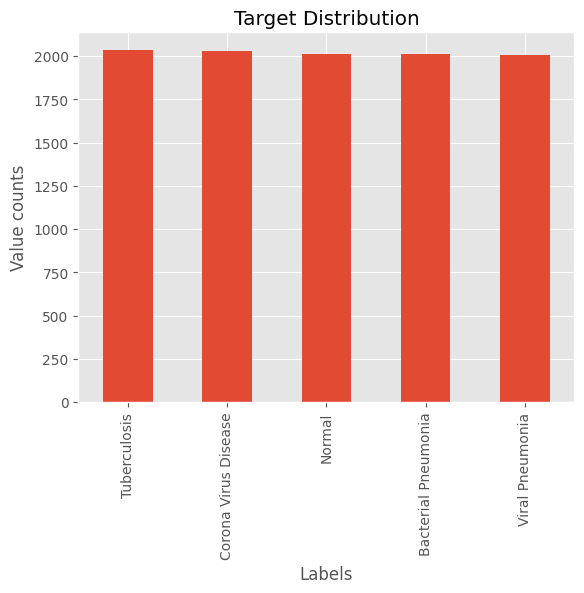

In [36]:
df["labels"].value_counts().plot(kind="bar",
                                 title="Target Distribution",
                                 xlabel="Labels",
                                 ylabel="Value counts")
plt.show()

In [37]:
Xtrain, Xtest, ytrain, ytest = train_test_split(df["images"], df["labels"], test_size=0.2, stratify=df["labels"], random_state=42)

xtest, xval, y_test, yval = train_test_split(Xtest, ytest, test_size=0.1, stratify=ytest, random_state=42)

print(Xtrain.shape, xtest.shape, xval.shape)

(8076,) (1817,) (202,)


In [38]:
for i in [Xtrain, ytrain, xtest, xval, y_test, yval]:
    i.reset_index(drop=True, inplace=True)

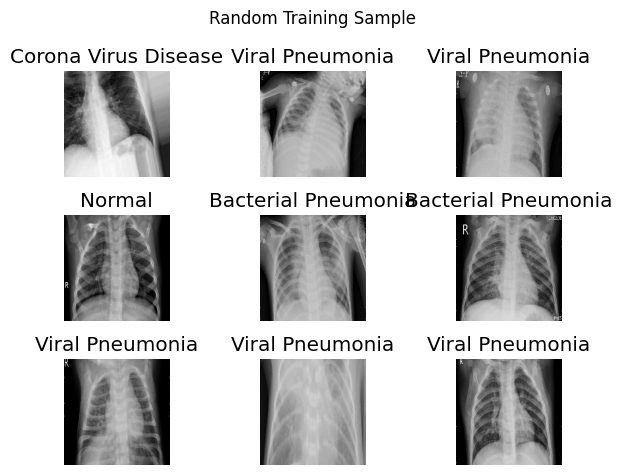

In [39]:
random_sample = np.random.randint(0, Xtrain.shape[0], 9)

for idx, i in enumerate(random_sample, start=1):
    plt.subplot(3,3,idx)
    load_image = load_img(Xtrain.iloc[i], target_size=(224, 224))
    plt.imshow(load_image)
    plt.title(f"{ytrain.iloc[i]}")
    plt.axis("off")

plt.suptitle("Random Training Sample")
plt.tight_layout()
plt.show()

In [40]:
def Prep_Image(df):
    data = []
    for i in df:
        load_image = load_img(i, target_size=(224, 224))
        data.append(efficientnet.preprocess_input(load_image))
    return np.array(data)

In [ ]:
prep_train = Prep_Image(Xtrain)
prep_test = Prep_Image(xtest)
prep_val = Prep_Image(xval)

In [ ]:
print(prep_train.shape)
print(prep_test.shape)
print(prep_val.shape)

In [ ]:
base_model_1 = EfficientNetB7(include_top=False, weights="imagenet", input_tensor=Input(shape=(224, 224, 3)))

In [ ]:
y_train = np.array(to_categorical(LabelEncoder().fit_transform(ytrain)))
y_test_ = np.array(to_categorical(LabelEncoder().fit_transform(y_test)))
y_val = np.array(to_categorical(LabelEncoder().fit_transform(yval)))

print(y_train.shape)
print(y_test_.shape)
print(y_val.shape)

In [ ]:
y_train

In [ ]:
for layer in  base_model_1.layers:
    layer.trainable = False

In [ ]:
base_model_output = base_model_1.output

# x = layers.Conv2D(filters=64, strides=(2, 2), kernel_size=(3, 3), activation="relu")(base_model_output)
x = layers.Dropout(rate=0.5)(base_model_output)
x = layers.BatchNormalization()(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(units=512, activation="relu")(x)
x = layers.Dropout(rate=0.5)(x)
x = layers.Dense(units=5, activation="softmax")(x)

model_1 = Model(inputs=base_model_1.input, outputs=x)

model_1.summary()

In [ ]:
model_1.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
generator = ImageDataGenerator(rotation_range=30,
                               zoom_range=0.2,
                               shear_range=0.2,
                               horizontal_flip=True,
                               fill_mode="nearest")

#  horizontal flip, zoom, shear, rotation, and rescale

In [21]:
model_1_history = model_1.fit(prep_train, y_train, batch_size=32,
                          validation_data=(prep_test, y_test_),
                          epochs=20,
                          callbacks=[callbacks.EarlyStopping(patience=5)])

253/253 [==============================] - 110s 436ms/step - loss: 0.2271 - accuracy: 0.9047 - val_loss: 0.3870 - val_accuracy: 0.8569
Epoch 8/20
253/253 [==============================] - 110s 437ms/step - loss: 0.2062 - accuracy: 0.9180 - val_loss: 0.3744 - val_accuracy: 0.8503
Epoch 9/20
253/253 [==============================] - 110s 436ms/step - loss: 0.1971 - accuracy: 0.9180 - val_loss: 0.3892 - val_accuracy: 0.8597


In [22]:
model_1.evaluate(prep_val, y_val)

7/7 [==============================] - 4s 627ms/step - loss: 0.2859 - accuracy: 0.8861


[0.28588518500328064, 0.8861386179924011]

<Axes: xlabel='Epoch', ylabel='Loss'>

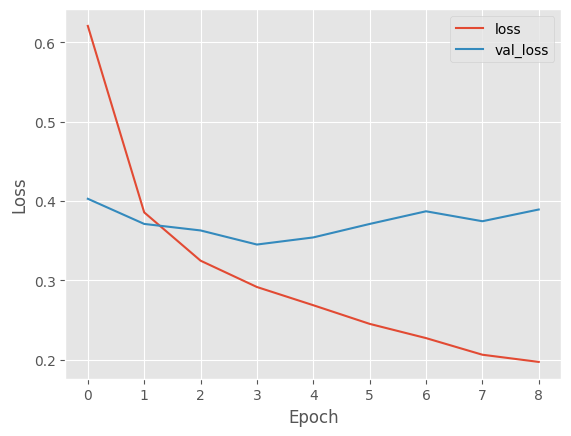

In [23]:
pd.DataFrame(model_1_history.history)[["loss", "val_loss"]].plot(xlabel="Epoch", ylabel="Loss")

<Axes: xlabel='Epoch', ylabel='Accuracy'>

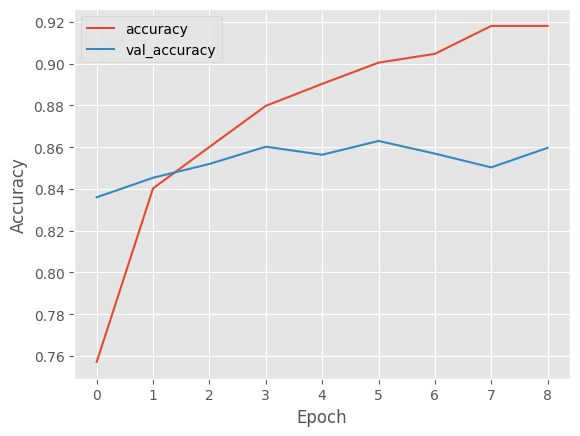

In [24]:
pd.DataFrame(model_1_history.history)[["accuracy", "val_accuracy"]].plot(xlabel="Epoch", ylabel="Accuracy")

In [25]:
base_model_2 = MobileNetV2(include_top=False, weights="imagenet", input_tensor=Input(shape=(224, 224, 3)))

9406464/9406464 [==============================] - 0s 0us/step


In [26]:
for layer in  base_model_2.layers:
    layer.trainable = False

In [27]:
base_model_output = base_model_2.output

# x = layers.Conv2D(filters=64, strides=(2, 2), kernel_size=(3, 3), activation="relu")(base_model_output)
x = layers.Dropout(rate=0.5)(base_model_output)
x = layers.BatchNormalization()(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(units=512, activation="relu")(x)
x = layers.Dropout(rate=0.5)(x)
x = layers.Dense(units=5, activation="softmax")(x)

model_2 = Model(inputs=base_model_2.input, outputs=x)

model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [28]:
model_2.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

In [29]:
model_2_history = model_2.fit(generator.flow(prep_train, y_train, batch_size=32),
                          validation_data=(prep_test, y_test_),
                          epochs=20,
                          callbacks=[callbacks.EarlyStopping(patience=5)])

Epoch 1/20
253/253 [==============================] - 95s 361ms/step - loss: 0.8685 - accuracy: 0.6828 - val_loss: 0.8557 - val_accuracy: 0.6351
Epoch 2/20
253/253 [==============================] - 89s 350ms/step - loss: 0.6362 - accuracy: 0.7590 - val_loss: 0.7238 - val_accuracy: 0.6957
Epoch 3/20
253/253 [==============================] - 91s 359ms/step - loss: 0.5789 - accuracy: 0.7781 - val_loss: 0.6947 - val_accuracy: 0.6962
Epoch 4/20
253/253 [==============================] - 95s 375ms/step - loss: 0.5510 - accuracy: 0.7827 - val_loss: 0.6105 - val_accuracy: 0.7446
Epoch 5/20
253/253 [==============================] - 94s 371ms/step - loss: 0.5196 - accuracy: 0.7973 - val_loss: 0.6898 - val_accuracy: 0.7001
Epoch 6/20
253/253 [==============================] - 95s 377ms/step - loss: 0.5027 - accuracy: 0.8030 - val_loss: 0.7056 - val_accuracy: 0.6819
Epoch 7/20
253/253 [==============================] - 96s 379ms/step - loss: 0.4932 - accuracy: 0.8034 - val_loss: 0.5996 - val_ac

<Axes: xlabel='Epoch', ylabel='Loss'>

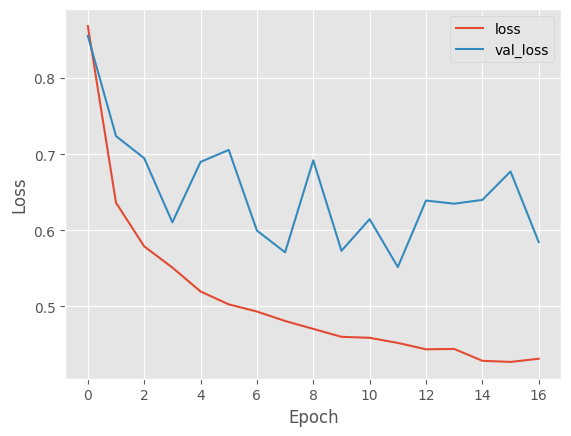

In [30]:
pd.DataFrame(model_2_history.history)[["loss", "val_loss"]].plot(xlabel="Epoch", ylabel="Loss")

<Axes: xlabel='Epoch', ylabel='Accuracy'>

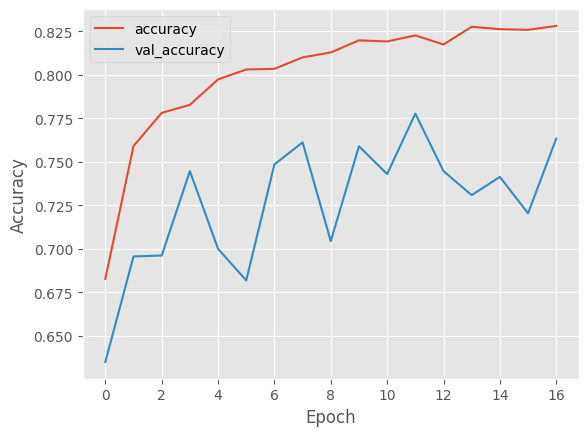

In [31]:
pd.DataFrame(model_2_history.history)[["accuracy", "val_accuracy"]].plot(xlabel="Epoch", ylabel="Accuracy")